In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def generateData(N, d):
    X = np.random.multivariate_normal(np.zeros(d), np.eye(d), N)
    mean = np.mean(X, axis=0)
    Y = np.random.multivariate_normal(np.zeros(d), np.eye(d), N)
    return X, mean, Y

def test(Xdot, Ydot, t):
    total = len(Xdot) + len(Ydot)
    return ((Xdot >= t).sum() + (Ydot < t).sum()) / total

def getBestTd(Xdot, Ydot):
    best_t = float('inf')
    best_acc = 0
    candidates = np.concatenate([Xdot, Ydot])
    for t in candidates:
        cur_acc = test(Xdot, Ydot, t)
        if cur_acc > best_acc:
            best_acc = cur_acc
            best_t = t
    return best_t, best_acc

Fix n = 50, variate dimensions

In [3]:
D_RANGE = range(10, 501)
N = 50

In [94]:
Tds = []
Accs = []
for d in tqdm(D_RANGE):
    X, mean, Y = generateData(N, d)
    Xdot = np.matmul(X, mean)
    Ydot = np.matmul(Y, mean)

    assert Xdot.shape == Ydot.shape
    assert Xdot.shape == (N,)

    best_t, best_acc = getBestTd(Xdot, Ydot)
    Tds.append(best_t)
    Accs.append(best_acc)


100%|██████████| 491/491 [00:26<00:00, 18.55it/s] 


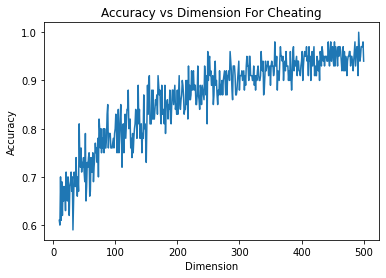

In [95]:
plt.plot(D_RANGE, Accs)
plt.xlabel('Dimension')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Dimension For Cheating')
plt.show()

"Generalize", generate X and Y freshly

In [96]:
generalized_acc = []
for i, d in tqdm(enumerate(D_RANGE), total=len(D_RANGE)):
    X, mean, Y = generateData(N, d)
    Xdot = np.matmul(X, mean)
    Ydot = np.matmul(Y, mean)

    assert Xdot.shape == Ydot.shape
    assert Xdot.shape == (N,)

    acc = test(Xdot, Ydot, Tds[i])
    generalized_acc.append(acc)

100%|██████████| 491/491 [00:26<00:00, 18.73it/s] 


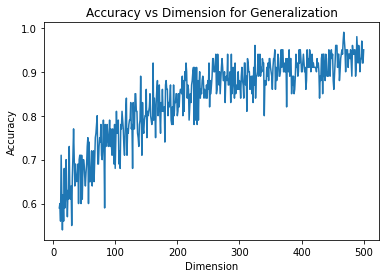

In [97]:
plt.plot(D_RANGE, generalized_acc)
plt.xlabel('Dimension')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Dimension for Generalization')
plt.show()

Investigate protection approach

In [98]:
d = 50
STEP = 0.05
VAR_RANGE = np.arange(0, 1 + STEP, STEP)
REPETITION = 1000

mean_two_norm = []
protected_acc = []
protected_tds = []
for var in tqdm(VAR_RANGE):
    running_acc = [0 for i in range(REPETITION)]
    running_tds = [0 for i in range(REPETITION)]
    running_norm = [0 for i in range(REPETITION)]
    for i in range(REPETITION):
        X, mean, Y = generateData(N, d)
        mean += np.random.multivariate_normal(np.zeros(d), np.eye(d) * var, 1).squeeze()
        Xdot = np.matmul(X, mean)
        Ydot = np.matmul(Y, mean)

        best_t, best_acc = getBestTd(Xdot, Ydot)

        # mean_two_norm.append(np.linalg.norm(mean))
        running_norm[i] = np.linalg.norm(mean)
        running_acc[i] = best_acc
        running_tds[i] = best_t
    mean_two_norm.append(np.mean(running_norm))
    protected_acc.append(np.mean(running_acc))
    protected_tds.append(np.mean(running_tds))

100%|██████████| 21/21 [00:41<00:00,  1.98s/it]


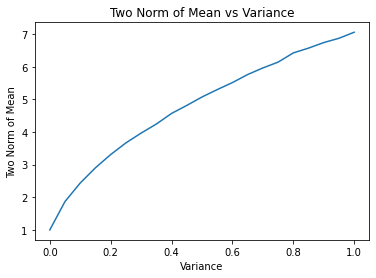

In [99]:
plt.plot(VAR_RANGE, mean_two_norm)
plt.xlabel('Variance')
plt.ylabel('Two Norm of Mean')
plt.title('Two Norm of Mean vs Variance')
plt.show()

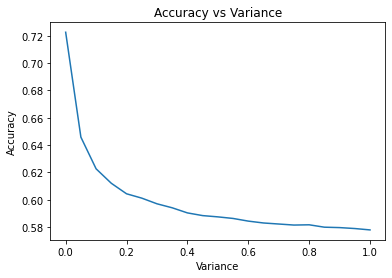

In [100]:
plt.plot(VAR_RANGE, protected_acc)
plt.xlabel('Variance')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Variance')
plt.show()

### B)

In [6]:
# from sklearn.datasets import fetch_mldata
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

download_data = True

transform = transforms.Compose(
    [transforms.ToTensor()])

# dataset and data loader
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=download_data, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=download_data, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset,  batch_size=1, shuffle=True)

print(train_dataset[0][0].shape)
X_train = train_dataloader.dataset.data.numpy().reshape(-1, 784)
print(X_train.shape)
Y_train = train_dataloader.dataset.targets.numpy()

X_test = test_dataloader.dataset.data.numpy().reshape(-1, 784)
Y_test = test_dataloader.dataset.targets.numpy()

N_CHOICES = [100, 200, 400, 800, 1600, 2500, 5000, 10000]

torch.Size([1, 28, 28])
(60000, 784)


In [ ]:
no_regu_test_scores = []
no_regu_train_scores = []
no_regu_models = []
for n in tqdm(N_CHOICES):
    clf = LogisticRegression(C=1000, solver='lbfgs', max_iter=100)
    clf.fit(X_train[:n,:], Y_train[:n])
    train_score = clf.score(X_train[:n,:], Y_train[:n])
    test_score = clf.score(X_test[:n,:], Y_test[:n])
    no_regu_test_scores.append(test_score)
    no_regu_train_scores.append(train_score)
    no_regu_models.append(clf)

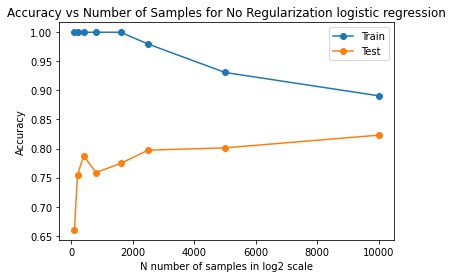

In [42]:
# plt.xticks(np.log2(N_CHOICES), N_CHOICES)
plt.plot(N_CHOICES, no_regu_train_scores, marker='o', label='Train')
plt.plot(N_CHOICES, no_regu_test_scores, marker='o', label='Test')
plt.legend()
plt.xlabel('N number of samples in log2 scale')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Samples for No Regularization logistic regression')
plt.show()

with l2 regularization

In [43]:
l2_regu_test_scores = []
l2_regu_train_scores = []
l2_regu_models = []
for n in tqdm(N_CHOICES):
    clf = LogisticRegression(C = 0.001, solver='lbfgs', max_iter=100)
    clf.fit(X_train[:n], Y_train[:n])
    train_score = clf.score(X_train[:n], Y_train[:n])
    test_score = clf.score(X_test[:n], Y_test[:n])
    l2_regu_test_scores.append(test_score)
    l2_regu_train_scores.append(train_score)
    l2_regu_models.append(clf)

  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 12%|█▎        | 1/8 [00:00<00:01,  4.69it/s]/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [44]:
print(l2_regu_train_scores)

[1.0, 1.0, 1.0, 1.0, 0.998125, 0.976, 0.9336, 0.8856]


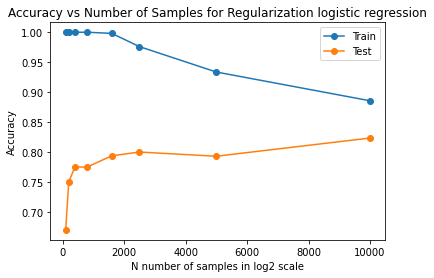

In [45]:
# plt.xticks(np.log2(N_CHOICES), N_CHOICES)
plt.plot(N_CHOICES, l2_regu_train_scores, marker='o', label='Train')
plt.plot(N_CHOICES, l2_regu_test_scores, marker='o', label='Test')
plt.legend(loc='best')
plt.xlabel('N number of samples in log2 scale')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Samples for Regularization logistic regression')
plt.show()

In [25]:
no_regu_attack_acc = []
l2_regu_attack_acc = []
for i, N in tqdm(enumerate(N_CHOICES), total = len(N_CHOICES)):
    no_model = no_regu_models[i]
    l2_model = l2_regu_models[i]
    no_regu_running_acc = 0
    l2_regu_running_acc = 0
    # labeled as IN set
    no_pred = no_model.predict(X_train[:N])
    l2_pred = l2_model.predict(X_train[:N])
    no_regu_running_acc += np.sum(no_pred == Y_train[:N]) / N
    l2_regu_running_acc += np.sum(l2_pred == Y_train[:N]) / N

    # labeled as OUT set
    no_pred = no_model.predict(X_test[:N])
    l2_pred = l2_model.predict(X_test[:N])
    no_regu_running_acc += np.sum(no_pred != Y_test[:N]) / N
    l2_regu_running_acc += np.sum(l2_pred != Y_test[:N]) / N
    
    no_regu_attack_acc.append(no_regu_running_acc / 2)
    l2_regu_attack_acc.append(l2_regu_running_acc / 2)

100%|██████████| 8/8 [00:00<00:00, 32.58it/s]


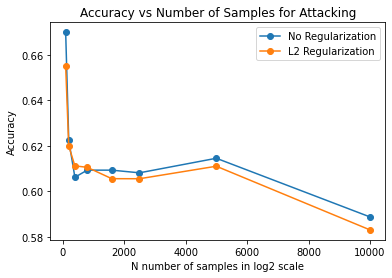

In [26]:

# plt.xticks(np.log2(N_CHOICES), N_CHOICES)
plt.plot(N_CHOICES, no_regu_attack_acc, marker='o')
plt.plot(N_CHOICES, l2_regu_attack_acc, marker='o')
plt.xlabel('N number of samples in log2 scale')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Samples for Attacking')
plt.legend(['No Regularization', 'L2 Regularization'])
plt.show()

In [ ]:
no_pred = no_regu_models[0].predict(X_train)
no_pred != Y_train

    for data, label in zip(X_train, Y_train):
        print(data.shape)
        print(data.reshape(-1, 1).shape)
        no_pred = no_model.predict(data)
        l2_pred = l2_model.predict(data)
        no_regu_running_acc += no_pred == label
        l2_regu_running_acc += l2_pred == label

    # labeled as OUT set
    for data, label in zip(X_test, Y_test):
        no_pred = no_model.predict(data)
        l2_pred = l2_model.predict(data)
        no_regu_running_acc += no_pred != label
        l2_regu_running_acc += l2_pred != label